In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from collections import defaultdict
import heapq
import json
import math
import time

import imageio
import loading
import tqdm

from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn import svm

In [2]:
"""DEFINE CONSTANTS HERE"""

DATA_PATH           = '../data'
VISUALIZATION_PATH  = '../visualization'

MISSING_VALUE       = '<NONE>'       # Used for the 'neighborhood' and 'city' attributes.
DEFAULT_NEI_P       = 0.2            # Default percentile of neighborhoods to keep.
DEFAULT_CITY_P      = 0.1            # Default percentile of cities to keep.
DEFAULT_ATT_P       = 1.0            # Default percentile of attributes to keep.
DEFAULT_CAT_P       = 0.5            # Default percentile of categories to keep.
DEFAULT_HRS_P       = 1.0            # Default percentile of hours to keep.

TIME_GRANULARITY    = 1              # Granularity (ticks/hr) of time calculations, factor of 60. 

In [3]:
"""Loads the json file of the given dataset name."""
def load(name):
  start = time.time()
  data = loading.read_df_from_json('%s/%s.json' % (DATA_PATH, name))
  print 'time to load \'%s\': %.3fs' % (name, time.time() - start)
  return data

In [4]:
"""Cleans the business dataset."""
def clean_business(business):
  print 'Replacing %s with %s.' % (u'Montréal', u'Montreal')
  business['city'].replace(to_replace=u'Montréal', 
                           value=u'Montreal',
                           inplace=True)

In [5]:
"""Plots all businesses on the world map for visualization purposes."""
def plot_business(business):
  points = business[['latitude', 'longitude']]

  img = imageio.imread(VISUALIZATION_PATH + '/raw_map.jpg').astype('int64')
  img = img / 4               # Dim map.
  img = img[8:-8,8:-8,:]      # Clip borders.
  H, W, _ = img.shape
  
  scalar = 10                 # Amount to add to each channel.
  delta = np.zeros((H, W), dtype='int64')
  
  def get_xy(latitude, longitude):
    x = (W - 1) * (180.0 + longitude) / 360.0
    y = (H - 1) * (90.0 - latitude) / 180.0
    return int(x), int(y)

  for row in points.itertuples():
    latitude, longitude = row.latitude, row.longitude
    if not math.isnan(latitude) and not math.isnan(longitude):
      x, y = get_xy(latitude, longitude)
      delta[y,x] += scalar

  img += np.expand_dims(delta, axis=-1).repeat(3, axis=-1)
  img = img.clip(0, 255).astype('uint8')
  
  return img

In [6]:
"""Returns the count_dict as a sorted list."""
def to_list(count_dict):
  return sorted([(k, count_dict[k]) for k in count_dict], key=lambda v: v[1])

In [7]:
"""Converts a dict of counts (key, int) into a list of top features.

   Takes either top N (int) features, or top PERCENTILE (float) by occurrence.

   Example usage:
     top_features(count_dict, 0.1)                  # Returns top 10% of elements.
     top_features(count_dict, top_n=5)              # Returns top 5 elements.
"""
def top_features(count_dict, percentile=None, n=None, verbose=True):
  if n is None:
    if percentile is None:
      raise Exception
    n = int(percentile * len(count_dict))

  l = heapq.nlargest(n, count_dict, key=lambda k: count_dict[k])
  
  if verbose:
    percentage = 0.0 if not len(count_dict) else 100.0 * n / len(count_dict)
    params = (n, len(count_dict), percentage, 0 if not l else count_dict[l[-1]])
    print 'Took %d elements out of %d (%2.1f%%). Cutoff was >= %d.' % params
    
  return l

In [8]:
"""Methods for converting a tuple from itertuples() to a feature list."""

# Return neighborhood concatenated with city, or MISSING_VALUE if empty. 
def get_neighborhood(tup):
  assert type(tup.neighborhood) is unicode
  return [tup.neighborhood + '/' + tup.city if tup.neighborhood else MISSING_VALUE]

# Return city, or MISSING_VALUE if empty.
def get_city(tup):
  assert type(tup.city) is unicode
  return [tup.city if tup.city else MISSING_VALUE]

# Recursively process attributes dict to get indicators for all attributes.
def get_attributes(tup):
  def _recurse(attributes, prefix):
    assert type(attributes) is dict
    l = []
    for k, v in attributes.items():
      if type(v) is bool:
        l.append(prefix + '/' + k)
      elif type(v) is unicode:
        l.append(prefix + '/' + k + '/' + v)
      elif type(v) is int:
        l.append(prefix + '/' + k + '/' + str(v))
      elif type(v) is dict:
        l += _recurse(attributes[k], prefix=k)
      else:
        assert False  # Invalid type in attributes.
    return l
  return _recurse(tup.attributes, prefix='')

# Return categories.
def get_categories(tup):
  assert type(tup.categories) is list
  return tup.categories

"""Helper methods for get_hours(), which determines which ticks of time the business is open.
   Each tick of time corresponds to an index in [0, _max_ticks()).

   In _time_to_dt_index, ROUND_UP determines what happens when the time falls
   in between ticks. By default, the time is rounded up.
"""
# An ordering of the days of the week, and a map from str --> index
_day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
_day_index = {d:i for i, d in enumerate(_day_order)}

# Maximum number of ticks
def _max_ticks():
  return 7 * 24 * TIME_GRANULARITY

# Given day of the week and time, returns the corresponding tick in [0, _max_ticks()).
def _time_to_dt_index(day, time, round_up=True):
  [hour, minutes] = time.split(':')
  hour_index = int(hour) * TIME_GRANULARITY
  min_index  = int(minutes) / (60 / TIME_GRANULARITY)
  if round_up and int(minutes) % (60 / TIME_GRANULARITY) > 0:
    min_index += 1
  return _day_index[day] * 24 * TIME_GRANULARITY + hour_index + min_index

# Cache the string corresponding to each tick of time.
_timestr_cache = ['%s/%02d:%02d' % (_day_order[day], hour, min_index * 60 / TIME_GRANULARITY)
                  for day in range(0, 7)
                  for hour in range(0, 24)
                  for min_index in range(0, TIME_GRANULARITY)]

def get_hours(tup):
  assert type(tup.hours) is dict
  l = []
  for day, hours in tup.hours.items():
    open_time, close_time = hours.split('-')
    open_index = _time_to_dt_index(day, open_time)
    close_index = _time_to_dt_index(day, close_time)

    assert 0 <= open_index and close_index <= _max_ticks()
    
    # Handle the case where close_index is for the following day.
    if close_index <= open_index:
      close_index += 24 * TIME_GRANULARITY
    
    # Append the slice of the _time_str_cache, handling wrap-around appropriately.
    l += _timestr_cache[open_index:min(close_index, _max_ticks())]
    if close_index > _max_ticks():
      l += _timestr_cache[0:close_index - _max_ticks()]
      
  return l

# Function to retrieve all features of a given row tuple.
all_fns = [get_neighborhood, get_city, get_attributes, get_categories, get_hours]
def get_all_features(tup):
  all_features = set([])
  for fn in all_fns:
    all_features |= set(fn(tup))
  return all_features

# Returns the value to regress on for the row tuple.
def get_target(tup):
  return float(tup.stars)

In [9]:
"""Get the features that we will use for 
   neighborhoods, cities, attributes, categories.

   By default, take:
     TOP 20% OF neighborhoods
     TOP 10% OF cities
         ALL OF attributes
     TOP 50% OF categories
         ALL OF hours
   
   Returns a length 6 tuple:
     (nei_set, city_set, att_set, cat_set, hours_set, debug_vals)
"""
def get_feature_sets(business, 
                     percentiles=[DEFAULT_NEI_P, DEFAULT_CITY_P, DEFAULT_ATT_P, 
                                  DEFAULT_CAT_P, DEFAULT_HRS_P]):
  
  fn_counts_percentile = zip(all_fns, [defaultdict(int) for _ in range(len(all_fns))], percentiles)

  for tup in tqdm.tqdm(business.itertuples()):
    for fn, counts, _ in fn_counts_percentile:
      features = fn(tup)
      for f in features:
        counts[f] += 1

  debug_val = [(fn.__name__, to_list(counts)) for fn, counts, _ in fn_counts_percentile]
  
  return [top_features(counts, percentile) for fn, counts, percentile in fn_counts_percentile], debug_val

In [10]:
"""Gets a mapping from feature name to feature index and vice versa."""
def get_feature_maps(feature_sets, start_index=0):  
  # Assert that there are no overlapping names.
  union = set([])
  for s in feature_sets:
    union |= set(s)
  assert len(union) == sum([len(s) for s in feature_sets])

  name_to_index, index_to_name = {}, {}
  for i, feature in enumerate(union):
    name_to_index[feature] = start_index + i
    index_to_name[start_index + i] = feature

  return name_to_index, index_to_name

In [11]:
"""Creates a list of data points for multivariate linear regression."""
def get_training_data(business, name_to_index):
  x = np.zeros((business.shape[0], len(name_to_index)), dtype='float32')
  y = np.zeros(business.shape[0], dtype='float32')
  
  for i, tup in tqdm.tqdm(enumerate(business.itertuples())):
    all_features = get_all_features(tup)
    for f in all_features:
      if f in name_to_index:
        x[i,name_to_index[f]] = 1
    y[i] = get_target(tup)
  
  return x, y

Run business regression.

NOT USABLE:
- business_id
- name

PROBABLY NOT USABLE:
- latitude
- longitude
- postal code
- address
- is_open
- review_count
- state

REGRESS ON:
- stars  (1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5)

FEATURES:
- neighborhood/city  --> indicators (~20%)
- city               --> indicators (~10%)
- attributes         --> indicators (process types differently, each has a separate indicator)
- categories         --> indicators (~50%)
- hours              --> indicators for every hour/half hour/quarter of the hour

In [12]:
business = load('business')
clean_business(business)

time to load 'business': 8.134s
Replacing Montréal with Montreal.


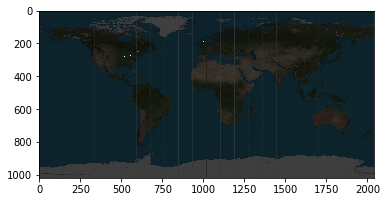

In [13]:
img = plot_business(business)
plt.imshow(img)
plt.show()
imageio.imsave(VISUALIZATION_PATH + '/business_map.jpg', img)

In [14]:
feature_sets, debug_val = get_feature_sets(business)

156639it [00:15, 10159.82it/s]

Took 146 elements out of 730 (20.0%). Cutoff was >= 77.
Took 100 elements out of 1009 (9.9%). Cutoff was >= 112.
Took 100 elements out of 100 (100.0%). Cutoff was >= 35.
Took 620 elements out of 1240 (50.0%). Cutoff was >= 58.
Took 168 elements out of 168 (100.0%). Cutoff was >= 6635.


In [15]:
feature_maps = get_feature_maps(feature_sets)
name_to_index, index_to_name = feature_maps  

In [16]:
x, y = get_training_data(business, name_to_index)

156639it [00:21, 7432.31it/s]


In [ ]:
reg = linear_model.LinearRegression()
reg.fit(x, y)

In [ ]:
print 'Intercept =', reg.intercept_
print

N = 15
coefs = [(index_to_name[i], c) for i, c in enumerate(reg.coef_)]
for n, c in heapq.nlargest(N, coefs, key=lambda v: v[1]):
  print n, c
print '...'
for n, c in reversed(heapq.nsmallest(N, coefs, key=lambda v: v[1])):
  print n, c

In [17]:
"""Splits list of data points 80/20 for training versus test."""
def training_test_split(x, y):
    indices = np.random.permutation(x.shape[0])
    cutoff = int(.8 * x.shape[0])
    training_idx, test_idx = indices[:cutoff], indices[cutoff+1:]
    x_train, x_test = x[training_idx,:], x[test_idx,:]
    y_train, y_test = y[training_idx], y[test_idx]
    return x_train, y_train, x_test, y_test

In [ ]:
x_train, y_train, x_test, y_test = training_test_split(x, y)
reg.fit(x_train, y_train)
y_pred = reg.predict(x_test)

In [ ]:
rmse = mean_squared_error(y_test, y_pred)
print "RMSE For Test Set ", rmse

In [ ]:
# Function to retrieve all non-category features of a given row tuple.
def get_non_categories(tup):
  non_categories = set([])
  for fn in [get_neighborhood, get_city, get_attributes, get_hours]:
    non_categories |= set(fn(tup))
  return non_categories

# Function to retrieve all location features of a given row tuple.
def get_locations(tup):
  locations = set([])
  for fn in [get_neighborhood, get_city]:
    locations |= set(fn(tup))
  return locations

"""Creates a list of data points for multivariate linear regression with category data only."""
def get_subset_training_data(business, name_to_index, retrieving_function):
  x = np.zeros((business.shape[0], len(name_to_index)), dtype='float32')
  y = np.zeros(business.shape[0], dtype='float32')
  
  for i, tup in tqdm.tqdm(enumerate(business.itertuples())):
    all_features = retrieving_function(tup)
    for f in all_features:
      if f in name_to_index:
        x[i,name_to_index[f]] = 1
    y[i] = get_target(tup)
  
  return x, y

In [ ]:
""" Find test RMSE for subset of training inputs. 
    x, y, are data to be split into training and test.
    retrieving_function specified subset of inputs
"""
def get_test_RMSE(x, y, retrieving_function):
    x, y = get_subset_training_data(business, name_to_index, retrieving_function)
    x_train, y_train, x_test, y_test = training_test_split(x, y)
    reg.fit(x_train, y_train)
    y_pred = reg.predict(x_test)
    return mean_squared_error(y_test, y_pred)

In [ ]:
category_rmse = get_test_RMSE(x, y, get_categories)
print "RMSE for training on category only ", category_rmse

In [ ]:
noncat_rmse = get_test_RMSE(x, y, get_non_categories)
print "RMSE for training on non-categories only ", noncat_rmse

In [ ]:
location_rmse = get_test_RMSE(x, y, get_locations)
print "RMSE for training on neighborhood and city only ", location_rmse

In [ ]:
hours_rmse = get_test_RMSE(x, y, get_hours)
print "RMSE for training on hours only ", hours_rmse

In [ ]:
attributes_rmse = get_test_RMSE(x, y, get_attributes)
print "RMSE for training on attributes only ", attributes_rmse

In [26]:
clf = svm.SVC(C=1, kernel='rbf')

In [27]:
x_train, y_train, x_test, y_test = training_test_split(x, y)
x_train = x_train[:10000]
y_train = y_train[:10000]
# scale output up to ints.
y_train *= 10
y_test *= 10
clf.fit(x_train, y_train)

SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
pred = clf.predict(x_test[:10000])

In [29]:
rmse = np.sqrt(mean_squared_error(y_test[:10000], pred))
print "RMSE For Test Set ", rmse

RMSE For Test Set  12.7235
